<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Аннотация:-прогнозирование-заказов-такси" data-toc-modified-id="Аннотация:-прогнозирование-заказов-такси-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Аннотация: прогнозирование заказов такси</a></span></li><li><span><a href="#Знакомство-с-данными" data-toc-modified-id="Знакомство-с-данными-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Знакомство с данными</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Обработка-данных" data-toc-modified-id="Обработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обработка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Подготовка-к-обучению-моделей" data-toc-modified-id="Подготовка-к-обучению-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка к обучению моделей</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы:" data-toc-modified-id="Выводы:-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Выводы:</a></span></li></ul></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Итоговые выводы</a></span></li></ul></div>

##  Аннотация: прогнозирование заказов такси

На основе исторических данных о заказах такси в аэропортах, предоставленных компанией «Чётенькое такси», нужно спрогнозировать количество заказов такси на следующий час. 

**Цель** проекта: построить модель, предсказывающую количество заказов такси и имеющую значение метрики *RMSE* на тестовой выборке не больше 48. 

**Задачи** проекта:
- провести анализ предоставленных данных;
- обучить разные модели с различными гиперпараметрами;
- проверить данные на тестовой выборке и сделать выводы.

## Знакомство с данными

In [33]:
#импортируем библиотеки и инструменты, которые понадобятся нам при выполнении проекта
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import copy
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

In [34]:
initial_data = pd.read_csv('/datasets/taxi.csv')

In [35]:
#выводим основную информацию об исходном датасете
print(initial_data.info())
print()
display(initial_data.head(10))
print()
display(initial_data.describe()) 
print()
print('Количество явных дубликатов:', initial_data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None



,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Количество явных дубликатов: 0


### Выводы:

Данные выглядят готовыми для дальнейшей работы, пропусков и явных дубликатов нет, однако смущает максимальное значение в столбце с количеством заказов.

На следующем этапе проверим данные на наличие выбросов и ресемплируем по одному часу.

## Обработка данных

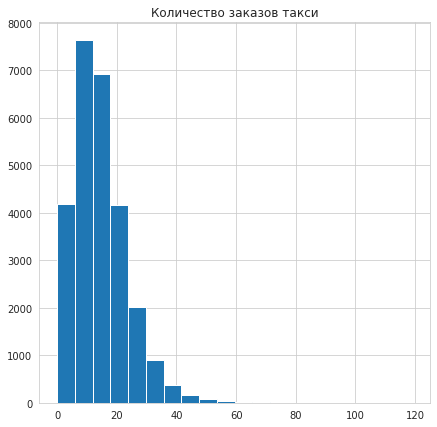

In [36]:
#проверим данные на наличие выбросов
initial_data.hist('num_orders', bins=20, figsize=(7,7))
plt.title('Количество заказов такси')
plt.show()

Данные скошены вправо, но аномальных значений, на мой взгляд, в них нет: вполне логично, что в определенное время суток потребность в услугах такси снижается до нуля, а в "часы-пик" взлетает до значениq в 60 и более заказов.

Далее ресемплируем наши данные по одному часу. Дабы сохранить исходную таблицу и не копировать ее, переоткроем данные заново и в дальнейшем будем работать с фреймом data.

In [37]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data_hour = data.resample('1H').sum()

### Выводы:

Мы проверили исходные данные на выбросы, отметили их скошенность, но значения вполне укладываются в норму и не выглядят ономальными в контексте задачи. 

Кроме того мы ресемплировали исходные данные для удобства их дальнейшего использования в создании моделей.

На следующем этапе произведем анализ предоставленных компанией данных.

## Анализ данных

Начнем анализ с выявления тренда и сезонности, прослеживающихся в данных. Для этого построим графики, применив специальную функцию seasonal_decompose().

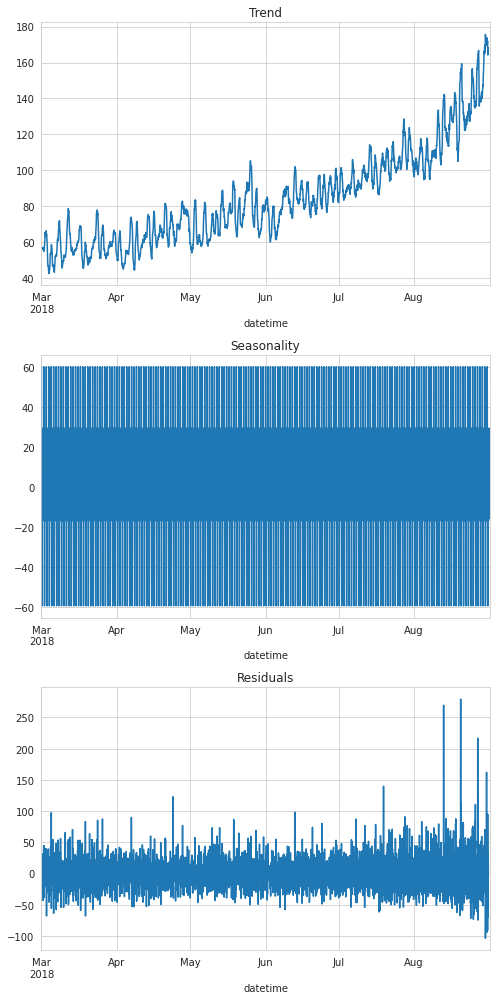

In [38]:
decomposed = seasonal_decompose(data_hour) #раскладываем данные на тренд, сезонность и остаток.

plt.figure(figsize=(7, 14)) #строим графики для визуализации и упрощения анализа результатов
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Графики получились не очень наглядными: виден тренд на увеличение заказов такси в течение рассматриваемого периода, определить сезонность не представляется возможным, шум не интерпритируется.

Попробуем взять более короткий период, например, первые пять дней августа, для выявления сезонности:

<AxesSubplot:xlabel='datetime'>

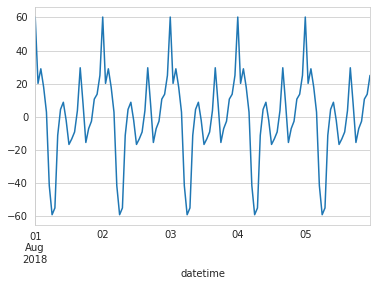

In [39]:
decomposed.seasonal['2018-08-01':'2018-08-05'].plot()

Теперь график наглядно показывает сезонность:
- пик заказов приходится на полночь;
- примерно после 2:30 начинается спад, и минимум заказов приходится на 6 утра;
- затем происходит резкий рост количества заказов вплоть до 10 часов утра;
- вновь спад, и следующий пик приходится примерно на 16 часов дня;
- начиная с 18 часов постепенное увеличение количества заказов вплоть до максимума в полночь.

Т.е. сезонные колебания количества заказов такси зависят от времени суток.

Теперь посмотрим динамику заказов внутри месяца. Ресемплируем даты по неделе и построим график. Возьмем данные за два месяца для сравнения, например, за май и август.

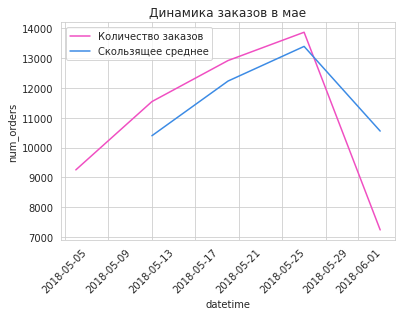

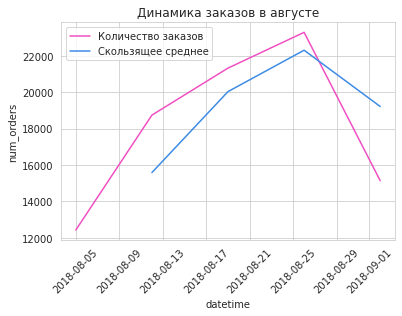

In [40]:
data_may = data['2018-05-01':'2018-05-31'].resample('1W').sum()
data_may['rolling_mean'] = data_may.rolling(2).mean()

sns.set_style("whitegrid")
sns.lineplot(data = data_may, x = "datetime", y ="num_orders", color='#f04fc2', label="Количество заказов")
sns.lineplot(data = data_may, x = "datetime", y ="rolling_mean", color='#3c8be5', label="Скользящее среднее")
plt.title('Динамика заказов в мае')
plt.legend()
plt.xticks(rotation=45)
plt.show()

data_august = data['2018-08-01':'2018-08-30'].resample('1W').sum()
data_august['rolling_mean'] = data_august.rolling(2).mean()

sns.lineplot(data = data_august, x = "datetime", y ="num_orders", color='#f04fc2', label="Количество заказов")
sns.lineplot(data = data_august, x = "datetime", y ="rolling_mean", color='#3c8be5', label="Скользящее среднее")
plt.title('Динамика заказов в августе')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Графики очень похожи между собой, четко видны закономерности:
- с начала месяца количество заказов постоянно растет;
- примерно 26-27 числа наступает пик, после которого количество заказов начинает резко снижаться.

Теперь посмотрим, как меняется количество заказов такси в течение недели. Сравним первую и последнюю полные недели августа.

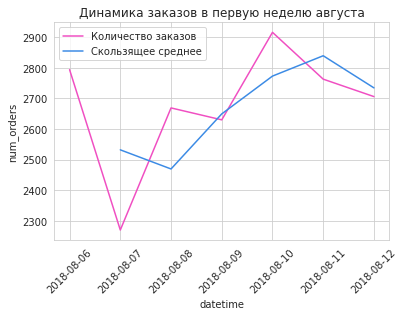

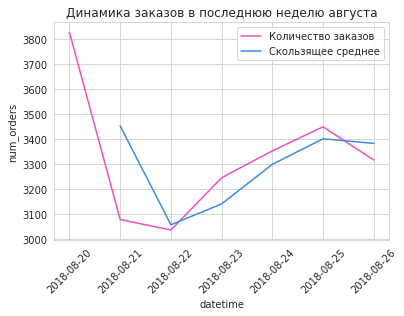

In [41]:
data_week_one = data['2018-08-06':'2018-08-12'].resample('1D').sum()
data_week_one['rolling_mean'] = data_week_one.rolling(2).mean()

sns.lineplot(data = data_week_one, x = "datetime", y ="num_orders", color='#f04fc2', label="Количество заказов")
sns.lineplot(data = data_week_one, x = "datetime", y ="rolling_mean", color='#3c8be5', label="Скользящее среднее")
plt.title('Динамика заказов в первую неделю августа')
plt.legend()
plt.xticks(rotation=45)
plt.show()


data_week_two = data['2018-08-20':'2018-08-26'].resample('1D').sum()
data_week_two['rolling_mean'] = data_week_two.rolling(2).mean()

sns.lineplot(data = data_week_two, x = "datetime", y ="num_orders", color='#f04fc2', label="Количество заказов")
sns.lineplot(data = data_week_two, x = "datetime", y ="rolling_mean", color='#3c8be5', label="Скользящее среднее")
plt.title('Динамика заказов в последнюю неделю августа')
plt.legend()
plt.xticks(rotation=45)
plt.show()

В данном случае графики сильно отличаются, говорить о закономерностях преждевременно. Посмотрим на динамику заказов в течение недели другого месяца - мая.

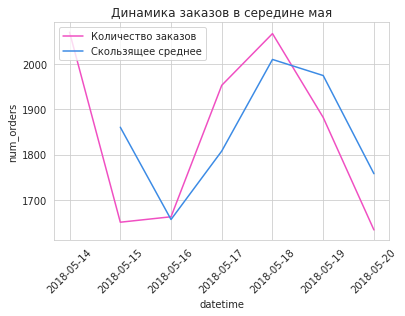

In [42]:
data_week_three = data['2018-05-14':'2018-05-20'].resample('1D').sum()
data_week_three['rolling_mean'] = data_week_three.rolling(2).mean()

sns.lineplot(data = data_week_three, x = "datetime", y ="num_orders", color='#f04fc2', label="Количество заказов")
sns.lineplot(data = data_week_three, x = "datetime", y ="rolling_mean", color='#3c8be5', label="Скользящее среднее")
plt.title('Динамика заказов в середине мая')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Третий график подтверждает, что динамика количества заказов такси меняется от неделе к неделе, однако определенные закономерности все же присутствуют. Меньше всего заказов приходится на вторник. Понедельник стабильно в топе, также в двух неделях из трех максимальное количество заказов приходится на пятницу.

### Выводы:

На данном этапе мы провели анализ исходных данных, который позволил выявить следующие особенности:
- существует тренд на увеличение заказов такси с течением времени;
- сезонные колебания количества заказов зависят от времени суток;
- каждый месяц начинается с роста количества заказов такси вплоть до 26-27 числа, после которых начинается резкое снижение;
- реже всего такси в аэропортах заказывают во вторник, чаще в понедельник и пятницу.

Теперь, когда мы тщательно изучили имеющиеся данные в различных разрезах, можем перейти к обучению моделей.

## Подготовка к обучению моделей

Прежде, чем начать обучение, необходимо скорректировать и дополнить данные, чтобы улучшить их качество. Для начала пропишем функцию, для создания признаков: календарных (час, месяц, день и день недели), отстающих значений и скользящего среднего. 

При создании отстающих значений учтем результаты анализа данных, проведенного ранее, а именно выявленную сезонность. Пик заказов приходится на полночь (24 часа), минимум - на 6 часов утра. Третьим значением возьмем 12, как связанное удвоением с этими значениями. 

При добавлении скользящего среднего учтем, что текущее значение ряда для расчёта применять нельзя, применим метод shift().

In [43]:
def make_features(data, rolling_mean_size): #создаем функцию
    new_data = copy.deepcopy(data)
    new_data['hour'] = data.index.hour
    new_data['month'] = data.index.month
    new_data['day'] = data.index.day
    new_data['dayofweek'] = data.index.dayofweek
    
    new_data['lag_6'] = new_data['num_orders'].shift(6)
    new_data['lag_12'] = new_data['num_orders'].shift(12)
    new_data['lag_24'] = new_data['num_orders'].shift(24)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data_hour, 6) #применяем к ресемплированным данным
new_data = new_data.dropna() #избавляемся от появившихся пропусков
display(new_data.head()) #выводим результат на экран

,num_orders,hour,month,day,dayofweek,lag_6,lag_12,lag_24,rolling_mean
datetime,,,,,,,,,
2018-03-02 00:00:00,90,0,3,2,4,73.0,30.0,124.0,69.333333
2018-03-02 01:00:00,120,1,3,2,4,45.0,32.0,85.0,72.166667
2018-03-02 02:00:00,75,2,3,2,4,61.0,48.0,71.0,84.666667
2018-03-02 03:00:00,64,3,3,2,4,66.0,66.0,66.0,87.000000
2018-03-02 04:00:00,20,4,3,2,4,113.0,43.0,43.0,86.666667


Теперь разделим данные на признаки и целевой признак, а также на обучающую, валидационную и тестовые выборки, помня о том, что последняя должна составлять 10% от исходных данных.

In [44]:
#выделяем признаки и целевой признак
features = new_data.drop('num_orders', axis=1)
target = new_data['num_orders']

#делим данные на выборки
features, features_test, target, target_test = train_test_split(features, target, test_size = 0.1, shuffle = False)
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.1111, shuffle = False)

print(features_train.shape, features_test.shape,  features_valid.shape) #проверяем оотношение

(3512, 8) (440, 8) (440, 8)


### Выводы:

Данные полностью готовы к обучению моделей: созданы дополнительные признаки, из датасета выделен целевой признак, данные разделены на выборки.
    
Переходим к этапу обучения.

## Обучение моделей

В данном проекте мы будем работать с моделями, знакомство с которыми состоялось в предыдущих проектах и которые показали высокие результаты: случайный лес, CatBoost, LGB. К ним присоединится и самая первая модель машинного обучения, которая была представлена в курсе - модель дерева решений. С большой долей вероятности, она не покажет впечатляющих результатов, но пригодится для сравнения. 

С нее и начнем.

In [45]:
#обучаем дерево решений
best_tree_model = None
best_tree_result = 10000
best_tree_depth = 0

for depth in range(1, 21):
            model_tree = DecisionTreeRegressor(random_state=12345,  max_depth=depth)
            model_tree.fit(features_train, target_train)
            predictions_valid = model_tree.predict(features_valid)
            result_tree = (mean_squared_error(target_valid, predictions_valid))**0.5
            if result_tree < best_tree_result:
                best_tree_model = model_tree
                best_tree_result = result_tree
                best_tree_depth = depth
                
print('Лучшая глубина модели:', best_tree_depth)
print('Лучший результат решающего дерева:', best_tree_result.round(3))

Лучшая глубина модели: 5
Лучший результат решающего дерева: 37.907


In [46]:
#обучаем случайный лес
best_forest_model = None
best_forest_result = 10000
best_forest_estimators = 0
best_forest_depth = 0

for est in range(1, 61, 10):
    for depth in range(1, 31):
            model_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
            model_forest.fit(features_train, target_train)
            predictions_valid = model_forest.predict(features_valid)
            result_forest = (mean_squared_error(target_valid, predictions_valid))**0.5
            if result_forest < best_forest_result:
                best_forest_model = model_forest
                best_forest_result = result_forest
                best_forest_estimators = est
                best_forest_depth = depth
                
print('Лучшее количество деревьев:', best_forest_estimators)
print('Лучшая глубина модели:', best_forest_depth)
print('Лучший результат случайного леса:', best_forest_result.round(3))

Лучшее количество деревьев: 51
Лучшая глубина модели: 25
Лучший результат случайного леса: 32.709


Для первых двух моделей лучшие значения гиперпараметров были подобраны автоматически, с помощью циклов. Значения параметров для оставшихся моделей будут подбираться через ручной перебор.

In [47]:
#обучаем CatBoost
cat_model = CatBoostRegressor(loss_function = 'RMSE', iterations = 1000, depth = 6, learning_rate = 0.03)
cat_model.fit(features_train, target_train, verbose = False)
pred_valid = cat_model.predict(features_valid) 
cat_result = round(((mean_squared_error(target_valid, pred_valid))**0.5), 3)
print(cat_result)

31.155


In [48]:
#обучаем LGB
train_data = lgb.Dataset(features_train, target_train)
validation_data = lgb.Dataset(features_valid, target_valid)
params_lgb = {'objective': 'regression', 'metric': 'root_mean_squared_error'}

lgb_model = lgb.train(params_lgb, train_data, num_boost_round = 100, valid_sets = (validation_data))
lgb_predictions = lgb_model.predict(features_valid)
lgb_result = round(((mean_squared_error(target_valid, lgb_predictions))**0.5), 3)
print(lgb_result)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 3512, number of used features: 8
[LightGBM] [Info] Start training from score 74.420273
[1]	valid_0's rmse: 55.5686
[2]	valid_0's rmse: 53.1306
[3]	valid_0's rmse: 50.86
[4]	valid_0's rmse: 48.8292
[5]	valid_0's rmse: 47.2025
[6]	valid_0's rmse: 45.7028
[7]	valid_0's rmse: 44.2712
[8]	valid_0's rmse: 43.0358
[9]	valid_0's rmse: 41.9764
[10]	valid_0's rmse: 41.198
[11]	valid_0's rmse: 40.2936
[12]	valid_0's rmse: 39.5693
[13]	valid_0's rmse: 38.7633
[14]	valid_0's rmse: 38.1556
[15]	valid_0's rmse: 37.5487
[16]	valid_0's rmse: 37.0026
[17]	valid_0's rmse: 36.5461
[18]	valid_0's rmse: 36.1573
[19]	valid_0's rmse: 35.823
[20]	valid_0's rmse: 35.5385
[21]	valid_0's rmse: 35.2675
[22]	valid_0's rmse: 35.0917
[23]	valid_0's rmse: 34.6802
[24

### Выводы:

Как и было предсказано, результат модели дерева решений на валидационной выборке значительно уступил остальным. Однако, вполне возможно, что на тестовой она покажет себя лучше. 

Наилучший результат у CatBoost, впрочем LGB-модель уступила ей совсем немного. На третьем месте, с чуть большим отрывом, расположилась модель случайного леса.

Теперь можно перейти к финальному тестированию моделей. 

## Тестирование

Чтобы соблюсти все условия поставленной задачи, обучим модели с подобранными значениями гиперпараметров на 90% данных и протестируем их на оставшихся 10%, приходящихся на тестовую выборку. 

Тестирование будем производить в том же порядке, что и обучение.

In [49]:
model_tree_test = DecisionTreeRegressor(random_state=12345,  max_depth=5)
model_tree_test.fit(features, target)
predictions_test = model_tree_test.predict(features_test)
result_tree_test = (mean_squared_error(target_test, predictions_test))**0.5
print('Результат решающего дерева:', result_tree_test.round(3))

Результат решающего дерева: 48.51


In [50]:
model_forest_test = RandomForestRegressor(random_state=12345, n_estimators=51, max_depth=25)
model_forest_test.fit(features, target)
predictions_test = model_forest.predict(features_test)
result_forest_test = (mean_squared_error(target_test, predictions_test))**0.5
print('Результат случайного леса:', result_forest_test.round(3))

Результат случайного леса: 52.989


In [51]:
cat_model_test = CatBoostRegressor(loss_function = 'RMSE', iterations = 1000, depth = 6, learning_rate = 0.03)
cat_model_test.fit(features, target, verbose = False)
predictions_test = cat_model_test.predict(features_test) 
cat_result_test = round(((mean_squared_error(target_test, predictions_test))**0.5), 3)
print(cat_result_test)

40.913


In [52]:
train_data = lgb.Dataset(features, target)
validation_data = lgb.Dataset(features_test, target_test)
params_lgb = {'objective': 'regression', 'metric': 'root_mean_squared_error'}

lgb_model_test = lgb.train(params_lgb, train_data, num_boost_round = 100, valid_sets = (validation_data))
lgb_predictions_test = lgb_model_test.predict(features_test)
lgb_result_test = round(((mean_squared_error(target_test, lgb_predictions_test))**0.5), 3)
print(lgb_result_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 894
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 8
[LightGBM] [Info] Start training from score 78.451417
[1]	valid_0's rmse: 80.2643
[2]	valid_0's rmse: 76.3842
[3]	valid_0's rmse: 72.9789
[4]	valid_0's rmse: 70.3666
[5]	valid_0's rmse: 67.9223
[6]	valid_0's rmse: 66.0641
[7]	valid_0's rmse: 63.9353
[8]	valid_0's rmse: 62.2256
[9]	valid_0's rmse: 60.4737
[10]	valid_0's rmse: 59.0548
[11]	valid_0's rmse: 57.4047
[12]	valid_0's rmse: 56.4141
[13]	valid_0's rmse: 54.8844
[14]	valid_0's rmse: 53.8555
[15]	valid_0's rmse: 52.7445
[16]	valid_0's rmse: 51.9709
[17]	valid_0's rmse: 51.3285
[18]	valid_0's rmse: 49.8434
[19]	valid_0's rmse: 49.4407
[20]	valid_0's rmse: 48.2932
[21]	valid_0's rmse: 47.8261
[22]	valid_0's rmse: 46.6333
[23]	valid_0's rmse: 46.1473

### Выводы:

После итогового тестирования положение моделей изменилось. Наилучший результат показала модель LGB, CatBoost, идущая следом, уступила ей почти 6 десятых. Модели дерева решений и случайного леса не смогли преодолеть порогового значения метрики качества, при этом дерево показало значительно лучший результат, нежели лес.

## Итоговые выводы

В ходе выполнения проекта по построению модели, предсказывающей количество заказов такси на основе исторических данных, были решены следующие задачи:
- проведен анализ исходных данных, который позволил выявить тренд на увеличение количества заказов и зависимость его сезонных колебаний от времени суток;
- обучены четыре различные модели машинного обучения, для каждой подобраны значения гиперпараметров;
- произведена финальная проверка отобранных моделей на тестовой выборке;
- оценено качество полученных предсказаний.

В результате, искомой моделью стала модель LGB с количеством деревьев бустинга в ансамбле, равным 100. Значение метрики качества данной модели на тестовой выборке составило 40.328.